In [1]:
%run PVModel_functions.ipynb

In [2]:
%run PVsystem_filterfunction_jack-may.ipynb

In [3]:
#This cell imports all the necessary packages & module data
import pandas as pd 
import numpy as np
from datetime import datetime
import datatools
import matplotlib as mpl
import matplotlib.pyplot as plt
import datetime
import pvlib
import pvanalytics
import math
import pvpltools
import seaborn as sns
from pvpltools import iec61853
from pvpltools.module_efficiency import adr, heydenreich, motherpv, pvgis, mpm5, mpm6, bilinear
from pvpltools.module_efficiency import fit_efficiency_model, fit_bilinear

%matplotlib inline 
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

mpl.rcParams['font.size']=12
mpl.rcParams['lines.linewidth']=1
mpl.rcParams['xtick.labelsize']=10
#mpl.rcParams['font.weight']='bold'
mpl.rcParams['axes.titlesize']=22

In [4]:
#This is where all the input info should be
#Valid module names : LG, Panasonic, Can270, Can275, HanQPlus, HanQPeak, MissionSolar, Jinko
mod_name = 'Panasonic'
mettablename =  'dbo.SNLA_Met_DataOut'

In [5]:
#Reads in an excel file of all necessary module coefficients, string lengths, system dates, etc
mod_info = pd.read_excel('module_coefficients.xlsx')
mod_info.index = mod_info['Manufacturer']
del mod_info['Manufacturer']
#defines the specific module given the previous user input and module coefficients file
module = mod_info[mod_name]
systablename = module['table_name']
start = '2020-01-01 00:00:00-07:00'
 #module['start']
end = '2021-01-01 00:00:00-07:00'
#module['end']

In [6]:
#Import sys & met databases & merge into one df
df = sys_met_data(mettablename, systablename, start, end)

In [7]:
len(df)

526743

In [8]:
t_amb = df['AmbientTemp_Avg']

In [9]:
#Calculate solpos & other environmental data, like airmass, aoi, and differnt poa components
sdf = calc_sol_data(df.index, module['latitude'], module['longitude'], module['tilt'], df['Pressure_mBar_Avg'])
edf = calc_env_data(module['tilt'], module ['altitude'], module['surface_azimuth'], sdf['azimuth'], sdf['apparent_zenith'], 
               df['Direct_Wm2_Avg'], df['Global_Wm2_Avg'], df['Diffuse_Wm2_Avg'], sdf['dni_extra'], model = 'haydavies')
edf['am_abs'] = pvlib.atmosphere.get_absolute_airmass(edf['airmass'], edf['pressure'])
#merge this information into one solar & environmental data df called 'sedf'
edf['t_amb'] = t_amb

In [10]:
#Apply Physical Filters 
#df = simple_filter(df, 'AmbientTemp_Avg', lower=-40, upper=60, apply=True)
#edf = simple_filter(edf, 'poa_global', lower=0, upper=1750, apply=True)
#edf = simple_filter(edf, 'poa_diffuse', lower=0, upper=1750, apply=True)

In [11]:
sapm_par = sapm_param(edf['poa_global'], edf['poa_direct'], edf['poa_diffuse'], df.AmbientTemp_Avg, df.Wind_Speed_Avg, 
                   edf['am_abs'], edf['aoi'], module)

sapm_tcell = sapm_par['tcell'].to_frame()
eff_irr  = sapm_par['eff_irr'].to_frame()
temp_irr = pd.merge(sapm_tcell,eff_irr, how = 'inner', left_index=True, right_index=True)
df = df.merge(temp_irr, how='inner', left_index=True, right_index=True)
df = df[~df.index.duplicated(keep='first')]

In [12]:
#Apply physical Filters
df = simple_filter(df, 'eff_irr', lower=50, upper=1200, apply=True)
df = simple_filter(df, 'tcell', lower=-40, upper=100, apply=True)

In [13]:
len(df)

526741

y=0.010x+0.024


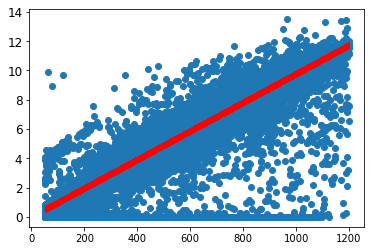

In [15]:
#Determine appropriate ratio for current v irrad filter
df.dropna(inplace=True)
z = np.polyfit( df['eff_irr'], df['LM1_I_Avg'],1)
p = np.poly1d(z)


plt.plot(df['eff_irr'], df['LM1_I_Avg'],  'o')
plt.plot(df['eff_irr'], p(df['eff_irr']), 'r--|')
#plt.ylim(-500, 2200)
print( f"y={z[0]:0.3f}x{z[1]:+0.3f}")


In [16]:
#Filter out the data points with a certain ratio of current to irradiance
string_is ='str_1_i', 'str_2_i', 'str_3_i', 'str_4_i'
ratio_names = 'ratio str_1_i to eff_irr', 'ratio str_2_i to eff_irr', 'ratio str_3_i to eff_irr', 'ratio str_4_i to eff_irr'
for string_i in string_is:
    df['ratio' + ' ' + string_i + ' ' 'to eff_irr'] = df[module[string_i]]/df['eff_irr'] 

for ratio_name in ratio_names:
    df = simple_filter(df, ratio_name, lower=0.005, upper=0.015, apply=True)

In [17]:
len(df)

225243

In [19]:
#Generate a results dataframe and add measured values
results = meas_val(df[module['str_1_v']],df[module['str_1_i']]).to_frame()
results['Str_2'] = meas_val(df[module['str_2_v']],df[module['str_2_i']])
results['Str_3'] = meas_val(df[module['str_3_v']],df[module['str_3_i']])
results['Str_4'] = meas_val(df[module['str_4_v']],df[module['str_4_i']])
results = results.resample('H').mean()
results.rename(columns = { 0 : 'Str_1'}, inplace = True)

In [20]:
#read in SAM data from the spreadsheet containing all SAM results for entire time period of system
sam_data = pd.read_excel('SAM_results.xlsx', sheet_name = [mod_name])
sam_data = sam_data[mod_name]
sam_data.index = sam_data['Time']
sam_data.index = pd.DatetimeIndex(sam_data.index)
del sam_data['Time']
sam_data.rename(columns = {mod_name : 'SAM'}, inplace = True)
sam_data = sam_data.loc[start:end, :]
results ['SAM'] = sam_data['SAM']#.resample('M').mean()

In [21]:
hourly_eff_irr = df['eff_irr'].resample('H').mean()

In [22]:
#Calcualte SAPM results and add to df
dc = sapm(df['eff_irr'], df['tcell'], module)
results['SAPM'] = sapm_p(dc['v_mp'], dc['i_mp'], module['str_len'])#.resample('M').mean()

In [23]:
#Calculate PVWatts results and add to df
results['PVWatts'] = (pvwatts(POA_eff = df['eff_irr'], cell_temp = df['tcell'], 
                             stc_mod_p = module['Power'], Gpmp = module['Gpmp'],str_len = module['str_len'],
                                                 temp_ref=25.0 ))#.resample('M').mean()

In [24]:
#Calculate CEC results and add to df
cec_param = pvlib.pvsystem.calcparams_cec( df['eff_irr'], df['tcell'], module['alpha_sc'], 
                                          module['a_ref'], module['I_L_ref'], module['I_o_ref'], module['R_sh_ref'], 
                                          module['R_s'], module['Adjust'], module['Cells_in_Series'])
cec_p = pvlib.pvsystem.singlediode(photocurrent = cec_param[0], saturation_current = cec_param[1], resistance_series =
                           cec_param[2], resistance_shunt = cec_param[3], nNsVth = cec_param[4], method = 'newton')
results['CEC'] = sdm(cec_p['p_mp'], module['str_len'])#.resample('M').mean()

In [25]:
#Calculate Desoto results and add to df
ds_param = pvlib.pvsystem.calcparams_desoto(df['eff_irr'], df['tcell'], module['alpha_sc'],
                                            module['a_ref'],module['I_L_ref'], module['I_o_ref'], 
                                            module['R_sh_ref'], module['R_s'])
ds_p = pvlib.pvsystem.singlediode(photocurrent = ds_param[0], saturation_current = ds_param[1], resistance_series =
                           ds_param[2], resistance_shunt = ds_param[3], nNsVth = ds_param[4], method = 'newton')
results['Desoto'] = sdm(ds_p['p_mp'], module['str_len'])#.resample('M').mean()

In [26]:
#Calculte PVSystem results and add to df
pvs_param = pvlib.pvsystem.calcparams_pvsyst(df['eff_irr'],df['tcell'], module['alpha_sc'], 
                                             module['gamma_ref'],module['mu_gamma'], module['I_L_ref'], module['I_o_ref'],
                                             module['R_sh_ref'], module['R_sh_0'], module['R_s'],  module['Cells_in_Series'])
pvs_p = pvlib.pvsystem.singlediode(photocurrent = pvs_param[0], saturation_current = pvs_param[1], resistance_series =
                           pvs_param[2], resistance_shunt = pvs_param[3], nNsVth = pvs_param[4], method = 'newton')
results['PVSyst'] = sdm(pvs_p['p_mp'], module['str_len'])#.resample('M').mean()

In [27]:
#Import matrix of measurement data
measurements_file = 'Sandia_PV_Module_P-Matrix-and-TempCo-Data_2019.xlsx'
matrix = pd.read_excel(measurements_file, sheet_name = mod_name, usecols='B,C,H', header=None, skiprows=5, nrows=27)
matrix.columns = ['temperature', 'irradiance', 'p_mp']
# calculate efficiency from power
matrix = matrix.eval('eta = p_mp / irradiance')
eta_stc = matrix.query('irradiance == 1000 and temperature == 25').eta
matrix.eta /= eta_stc.values
# just keep the columns that are needed
matrix = matrix[['irradiance', 'temperature', 'eta']]

#Until the other function is complete, I have this setup just to get out all negative values, but it leads to problems at times
#df.loc[df['BroadbandPOA_Avg']<0, 'BroadbandPOA_Avg'] = 0

In [28]:
#Calculate ADR results and add to df
popt, pcov = fit_efficiency_model(matrix.irradiance,matrix.temperature,matrix.eta,adr)
adr_eff = adr(df['eff_irr'], df['tcell'], *popt)
adr_p = (df['eff_irr']/1000) * (adr_eff) * (module['Power']) *12
results['ADR'] = adr_p.resample('H').mean()

In [29]:
#Calculate Heydenreich results and add to df
popt, pcov = fit_efficiency_model(matrix.irradiance,matrix.temperature,matrix.eta,heydenreich)
hey_eff = heydenreich(df['eff_irr'], df['tcell'], *popt)
hey_p = (df['eff_irr']/1000) * (hey_eff) * (module['Power']) *12
results['Heydenreich'] = hey_p.resample('H').mean()

In [30]:
#Calculate MotherPV results and add to df
popt, pcov = fit_efficiency_model(matrix.irradiance,matrix.temperature,matrix.eta,motherpv)
mother_eff = motherpv(df['eff_irr'], df['tcell'], *popt)
mother_p = (df['eff_irr']/1000) * (mother_eff) * (module['Power']) * 12
results['Mother'] = mother_p.resample('H').mean()

In [31]:
#Calculate PVGIS results and add to df
popt, pcov = fit_efficiency_model(matrix.irradiance,matrix.temperature,matrix.eta,pvgis)
pvgis_eff = pvgis(df['eff_irr'], df['tcell'], *popt)
pvgis_p = (df['eff_irr']/1000) * (pvgis_eff) * (module['Power']) *12
results['PVGIS'] = pvgis_p.resample('H').mean()

In [32]:
#Calculate MPM5 results and add to df
popt, pcov = fit_efficiency_model(matrix.irradiance,matrix.temperature,matrix.eta,mpm5)
mpm5_eff = mpm5(df['eff_irr'], df['tcell'], *popt)
mpm5_p = (df['eff_irr']/1000) * (mpm5_eff) * (module['Power']) *12
results['MPM5'] = mpm5_p.resample('H').mean()

In [33]:
#Calculate MPM6 results and add to df
popt, pcov = fit_efficiency_model(matrix.irradiance,matrix.temperature,matrix.eta,mpm6)
mpm6_eff = mpm6(df['eff_irr'], df['tcell'], *popt)
mpm6_p = (df['eff_irr']/1000) * (mpm6_eff) * (module['Power']) *12
results['MPM6'] = mpm6_p.resample('H').mean()

In [34]:
#Aligns SAM results with other results since SAM results has 0's in between days instead of NaNs
mask = np.isnan(results['Str_1'])
results = results.mask(mask, np.nan)

In [35]:
#Statistical Sig3 filter
results, mask = stat_sigma_test(results, deviation = 3, apply=True)
results=results.astype(float)

In [36]:
#Begin Error Calculations


measureds = ['Str_1', 'Str_2', 'Str_3', 'Str_4']
models = ['SAM', 'SAPM',  'ADR', 'Heydenreich', 'Mother', 'PVGIS', 'MPM5', 'MPM6','PVWatts', 'CEC', 'Desoto', 'PVSyst']
#calculate absolute differences
ad = abs(results['Str_1']-results['SAM']).to_frame()
ad.rename(columns = { 0 : 'SAM Str_1'}, inplace = True)
ad.index = results.index
for model in models:
    for measured in measureds:
        ad[model + ' ' + measured] = abs(results[measured]-results[model])

        
#calculate absolute percentage differences
apd = 100*abs((results['SAM']-results['Str_1'])/results['Str_1']).to_frame()
apd.rename(columns = { 0 : 'SAM Str_1'}, inplace = True)
apd.index = results.index
for model in models:
    for measured in measureds:
        apd[model + ' ' + measured] = 100* abs((results[measured]-results[model])/results[measured])

In [37]:
ad['Heydenreich Str_1'].sort_values(ascending=False)

TmStamp
2020-02-05 12:00:00-07:00    914.557796
2020-12-24 07:00:00-07:00    500.605073
2020-12-25 07:00:00-07:00    497.821269
2020-12-31 07:00:00-07:00    473.923946
2020-12-21 07:00:00-07:00    470.379911
                                ...    
2020-12-31 02:00:00-07:00           NaN
2020-12-31 03:00:00-07:00           NaN
2020-12-31 04:00:00-07:00           NaN
2020-12-31 05:00:00-07:00           NaN
2020-12-31 06:00:00-07:00           NaN
Name: Heydenreich Str_1, Length: 8770, dtype: float64

In [38]:
len(df)

225243

In [39]:
#Calculate MAPE according to different time intervals (Day, Month, Yearly)
#dmape = apd.resample('D').mean()
#dmape.drop(columns = ['SAM', 'SAPM'], inplace = True)
#mmape = apd.resample('M').mean()
#mmape.drop(columns = ['SAM', 'SAPM'], inplace = True)
ymape = apd.resample('Y').mean()
#ymape.drop(columns = ['SAM', 'SAPM'], inplace = True)

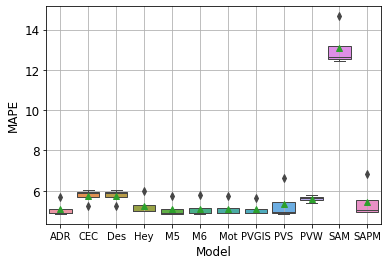

In [40]:
# Organize values into meta frame to be plotted
t_ymape = ymape.transpose()
t_ymape.sort_index(ascending=True, inplace=True)

meta = {'Model': ['ADR','ADR','ADR','ADR','CEC','CEC','CEC','CEC','Des','Des','Des','Des','Hey',
                'Hey','Hey','Hey', 'M5','M5','M5','M5','M6','M6','M6','M6', 
                'Mot','Mot','Mot','Mot','PVGIS','PVGIS','PVGIS','PVGIS','PVS', 'PVS', 
                'PVS','PVS','PVW','PVW','PVW','PVW','SAM','SAM','SAM','SAM','SAPM','SAPM','SAPM','SAPM']}
meta = pd.DataFrame(meta)
meta['String #'] = ['Str 1', 'Str 2', 'Str 3', 'Str 4', 'Str 1', 'Str 2', 'Str 3', 'Str 4','Str 1', 'Str 2', 'Str 3', 'Str 4',
                   'Str 1', 'Str 2', 'Str 3', 'Str 4','Str 1', 'Str 2', 'Str 3', 'Str 4','Str 1', 'Str 2', 'Str 3', 'Str 4',
                  'Str 1', 'Str 2', 'Str 3', 'Str 4','Str 1', 'Str 2', 'Str 3', 'Str 4','Str 1', 'Str 2', 'Str 3', 'Str 4',
                   'Str 1', 'Str 2', 'Str 3', 'Str 4','Str 1', 'Str 2', 'Str 3', 'Str 4','Str 1', 'Str 2', 'Str 3', 'Str 4']
meta['MAPE'] = t_ymape['2020-12-31 00:00:00-07:00'].to_list()

ax = sns.boxplot(x = 'Model', y = 'MAPE', data = meta, showmeans=True)
ax.grid(True)
#ax.set_ylim([0,50])

(0.0, 4000.0)

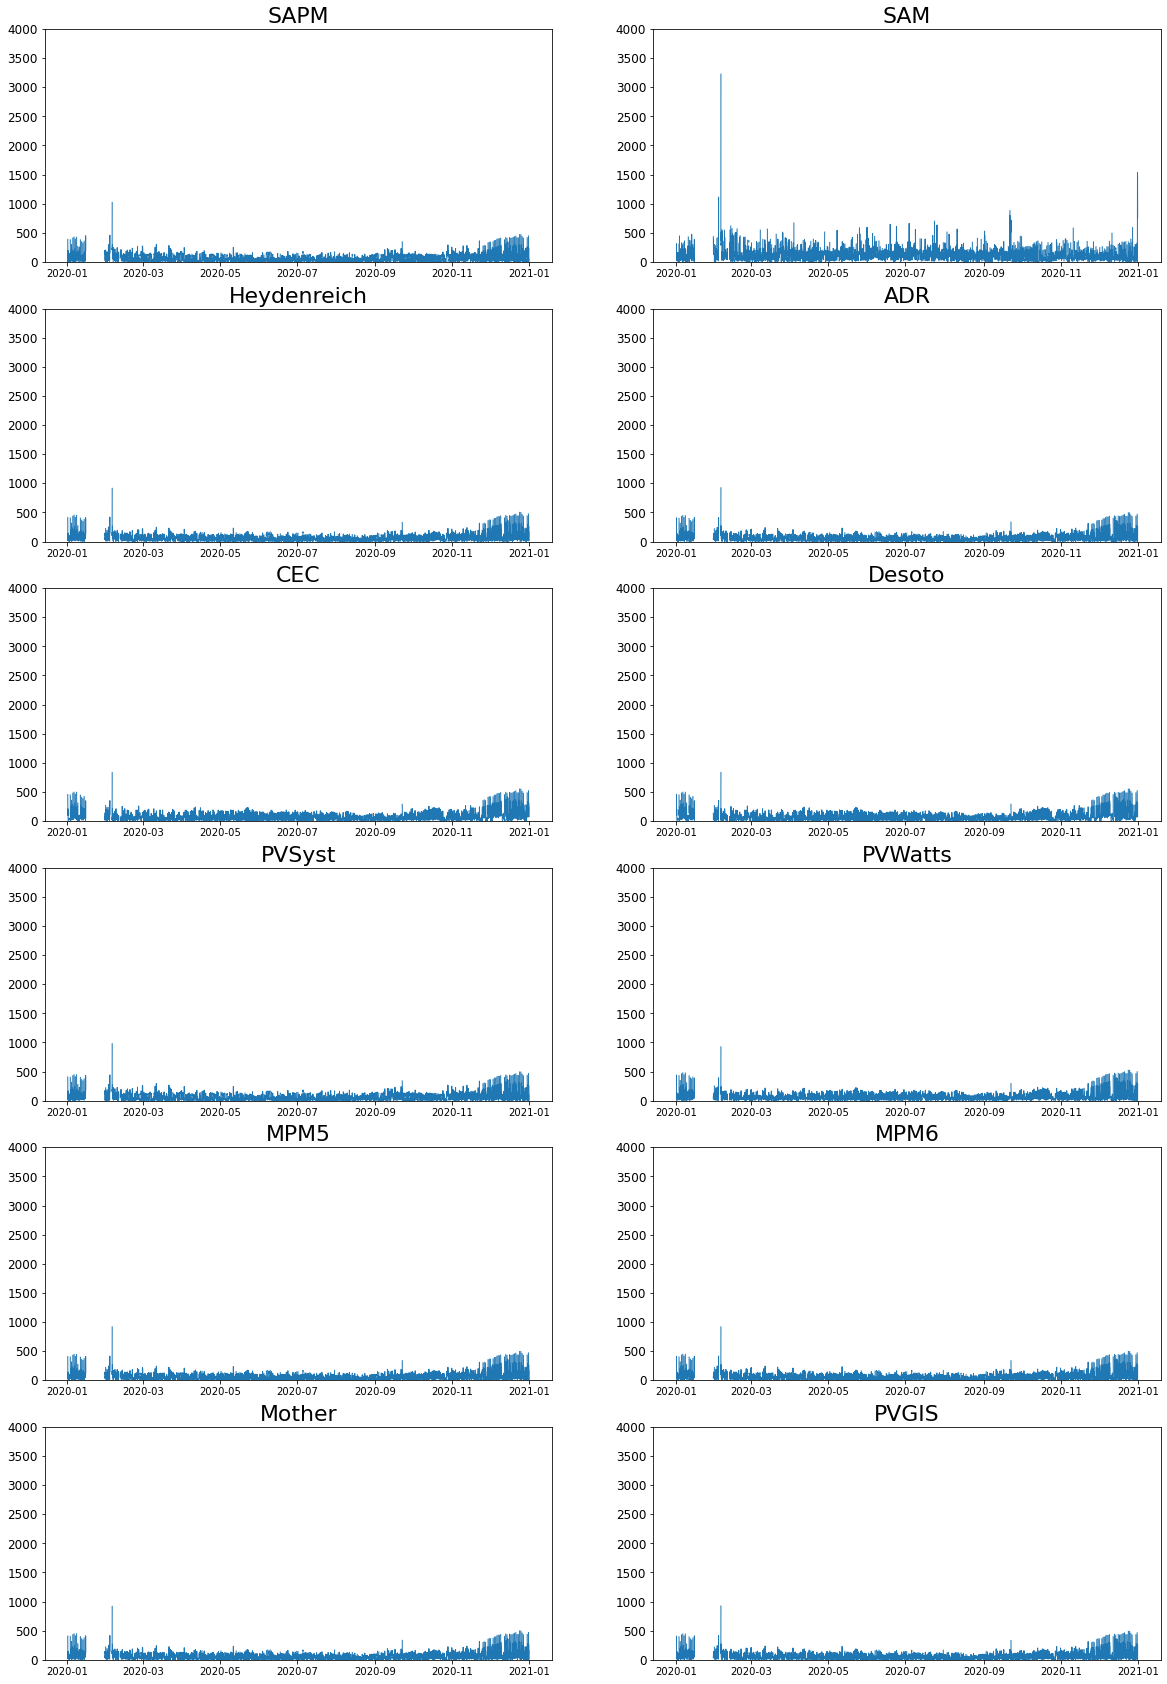

In [41]:
figs, axs = plt.subplots(6, 2, figsize = (20,30))
axs[0,0].plot(ad['SAPM Str_1'])
axs[0,0].set_title('SAPM')
axs[0,0].set_ylim(0,4000)
axs[0,1].plot(ad['SAM Str_1'])
axs[0,1].set_title('SAM')
axs[0,1].set_ylim(0,4000)
axs[1,0].plot(ad['Heydenreich Str_1'])
axs[1,0].set_title('Heydenreich')
axs[1,0].set_ylim(0,4000)
axs[1,1].plot(ad['ADR Str_1'])
axs[1,1].set_title('ADR')
axs[1,1].set_ylim(0,4000)
axs[2,0].plot(ad['CEC Str_1'])
axs[2,0].set_title('CEC')
axs[2,0].set_ylim(0,4000)
axs[2,1].plot(ad['Desoto Str_1'])
axs[2,1].set_title('Desoto')
axs[2,1].set_ylim(0,4000)
axs[3,0].plot(ad['PVSyst Str_1'])
axs[3,0].set_title('PVSyst')
axs[3,0].set_ylim(0,4000)
axs[3,1].plot(ad['PVWatts Str_1'])
axs[3,1].set_title('PVWatts')
axs[3,1].set_ylim(0,4000)
axs[4,0].plot(ad['MPM5 Str_1'])
axs[4,0].set_title('MPM5')
axs[4,0].set_ylim(0,4000)
axs[4,1].plot(ad['MPM6 Str_1'])
axs[4,1].set_title('MPM6')
axs[4,1].set_ylim(0,4000)
axs[5,0].plot(ad['Mother Str_1'])
axs[5,0].set_title('Mother')
axs[5,0].set_ylim(0,4000)
axs[5,1].plot(ad['PVGIS Str_1'])
axs[5,1].set_title('PVGIS')
axs[5,1].set_ylim(0,4000)

Text(0.5, 0, 'Power')

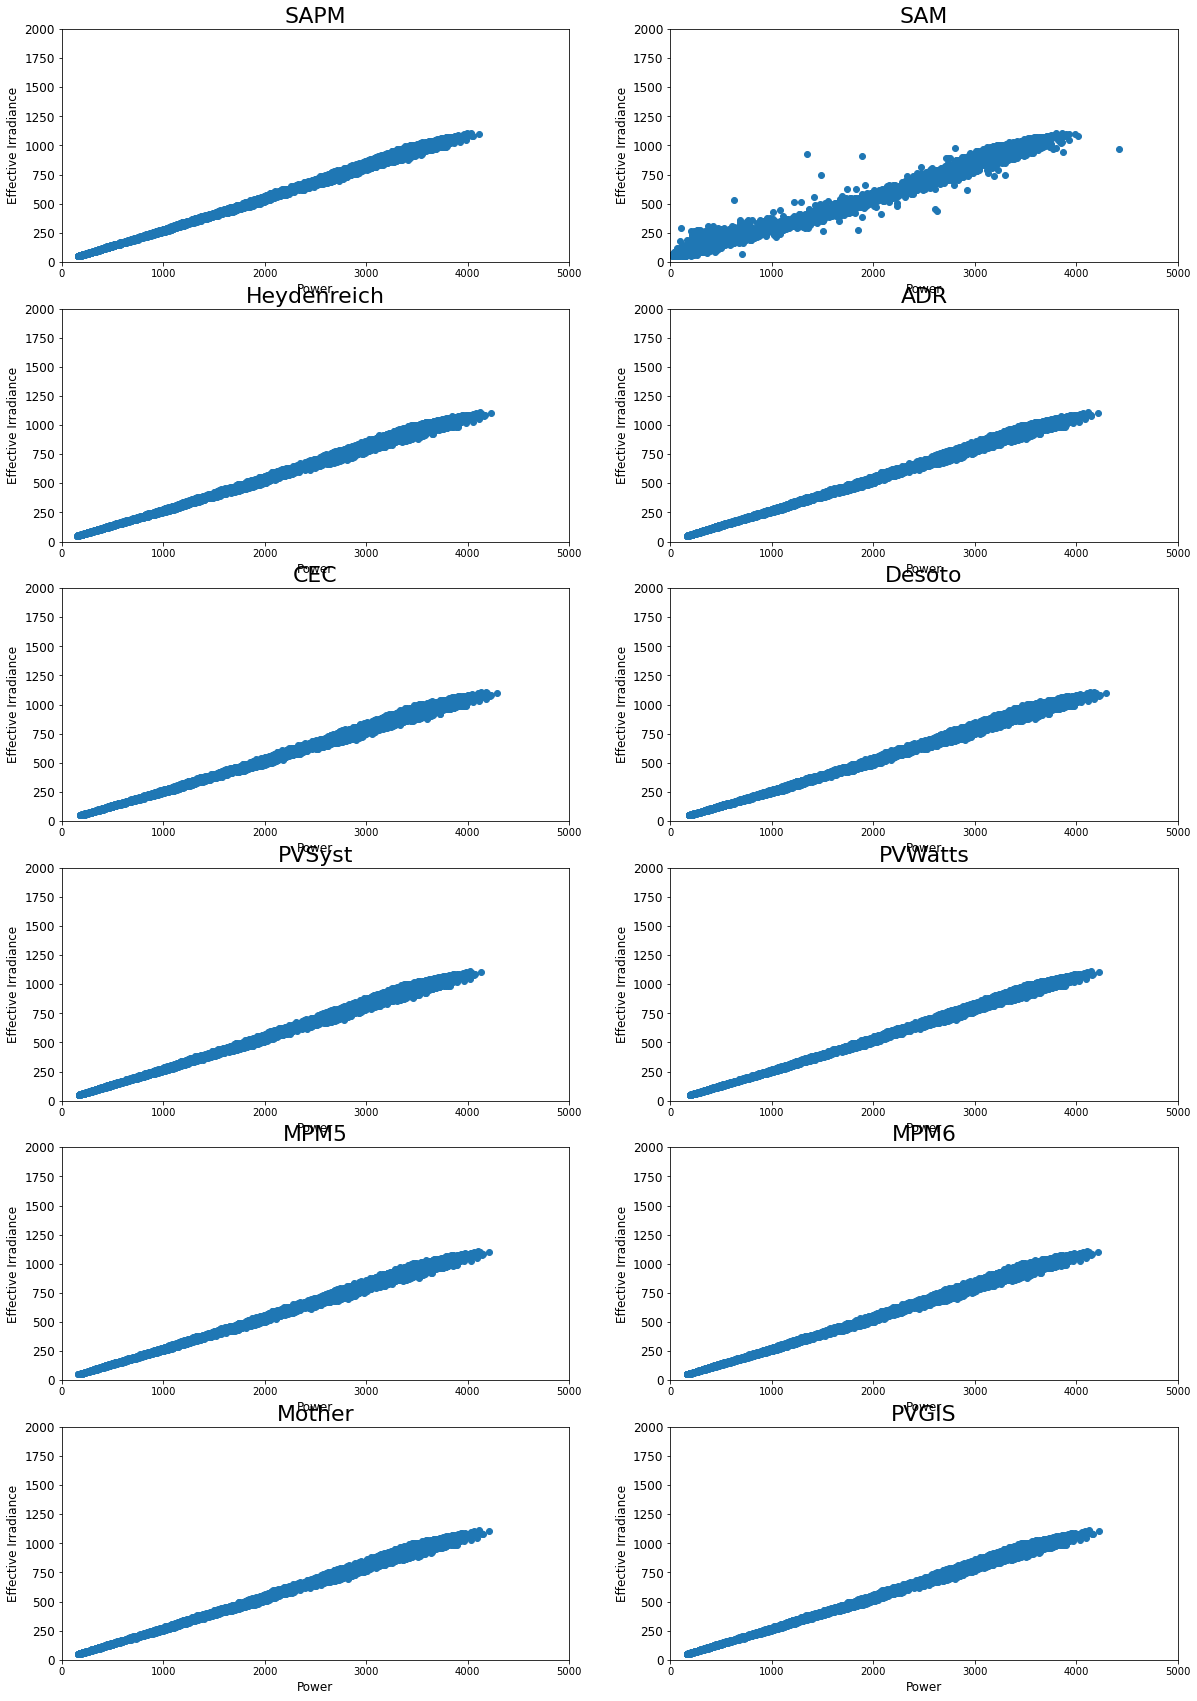

In [42]:
figs, axs = plt.subplots(6, 2, figsize = (20,30))
axs[0,0].scatter(results['SAPM'], hourly_eff_irr)
axs[0,0].set_title('SAPM')
axs[0,0].set_xlim(0,5000)
axs[0,0].set_ylim(0,2000)
axs[0,0].set_ylabel('Effective Irradiance')
axs[0,0].set_xlabel('Power')
axs[0,1].scatter(results['SAM'], hourly_eff_irr)
axs[0,1].set_title('SAM')
axs[0,1].set_xlim(0,5000)
axs[0,1].set_ylim(0,2000)
axs[0,1].set_ylabel('Effective Irradiance')
axs[0,1].set_xlabel('Power')
axs[1,0].scatter(results['Heydenreich'], hourly_eff_irr)
axs[1,0].set_title('Heydenreich')
axs[1,0].set_xlim(0,5000)
axs[1,0].set_ylim(0,2000)
axs[1,0].set_ylabel('Effective Irradiance')
axs[1,0].set_xlabel('Power')
axs[1,1].scatter(results['ADR'], hourly_eff_irr)
axs[1,1].set_title('ADR')
axs[1,1].set_xlim(0,5000)
axs[1,1].set_ylim(0,2000)
axs[1,1].set_ylabel('Effective Irradiance')
axs[1,1].set_xlabel('Power')
axs[2,0].scatter(results['CEC'], hourly_eff_irr)
axs[2,0].set_title('CEC')
axs[2,0].set_xlim(0,5000)
axs[2,0].set_ylim(0,2000)
axs[2,0].set_ylabel('Effective Irradiance')
axs[2,0].set_xlabel('Power')
axs[2,1].scatter(results['Desoto'], hourly_eff_irr)
axs[2,1].set_title('Desoto')
axs[2,1].set_xlim(0,5000)
axs[2,1].set_ylim(0,2000)
axs[2,1].set_ylabel('Effective Irradiance')
axs[2,1].set_xlabel('Power')
axs[3,0].scatter(results['PVSyst'], hourly_eff_irr)
axs[3,0].set_title('PVSyst')
axs[3,0].set_xlim(0,5000)
axs[3,0].set_ylim(0,2000)
axs[3,0].set_ylabel('Effective Irradiance')
axs[3,0].set_xlabel('Power')
axs[3,1].scatter(results['PVWatts'], hourly_eff_irr)
axs[3,1].set_title('PVWatts')
axs[3,1].set_xlim(0,5000)
axs[3,1].set_ylim(0,2000)
axs[3,1].set_ylabel('Effective Irradiance')
axs[3,1].set_xlabel('Power')
axs[4,0].scatter(results['MPM5'], hourly_eff_irr)
axs[4,0].set_title('MPM5')
axs[4,0].set_xlim(0,5000)
axs[4,0].set_ylim(0,2000)
axs[4,0].set_ylabel('Effective Irradiance')
axs[4,0].set_xlabel('Power')
axs[4,1].scatter(results['MPM6'], hourly_eff_irr)
axs[4,1].set_title('MPM6')
axs[4,1].set_xlim(0,5000)
axs[4,1].set_ylim(0,2000)
axs[4,1].set_ylabel('Effective Irradiance')
axs[4,1].set_xlabel('Power')
axs[5,0].scatter(results['Mother'], hourly_eff_irr)
axs[5,0].set_title('Mother')
axs[5,0].set_xlim(0,5000)
axs[5,0].set_ylim(0,2000)
axs[5,0].set_ylabel('Effective Irradiance')
axs[5,0].set_xlabel('Power')
axs[5,1].scatter(results['PVGIS'], hourly_eff_irr)
axs[5,1].set_title('PVGIS')
axs[5,1].set_xlim(0,5000)
axs[5,1].set_ylim(0,2000)
axs[5,1].set_ylabel('Effective Irradiance')
axs[5,1].set_xlabel('Power')


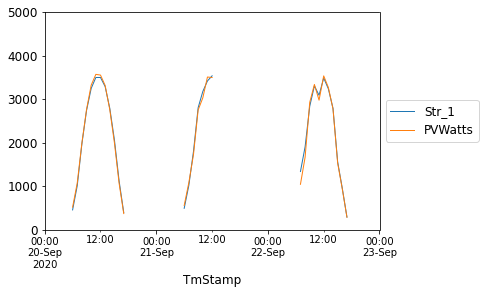

In [43]:
results['Str_1'].plot()
results['PVWatts'].plot()
#df['eff_irr'].plot()
plt.xlim('2020-09-20 00:00:00-07:00', '2020-09-23 00:00:00-07:00')
plt.ylim(0,5000)
plt.legend(loc='center left', bbox_to_anchor=(1,0.5))

(0.0, 1200.0)

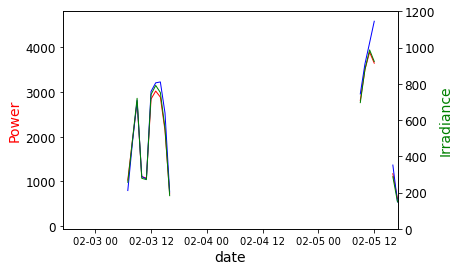

In [44]:
# create figure and axis objects with subplots()
fig,ax = plt.subplots()

# make a plot
ax.plot(results.index, results['PVWatts'], color="red")
ax.plot(results.index, results['Str_2'], color = "blue")
ax.set_xlim(datetime.date(2020, 2, 3), datetime.date(2020,2,6))
# set x-axis label
ax.set_xlabel("date",fontsize=14)
# set y-axis label
ax.set_ylabel("Power",color="red",fontsize=14)
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(results.index, hourly_eff_irr,color="green")
ax2.set_ylabel("Irradiance",color="green",fontsize=14)
ax2.set_ylim(0, 1200)
#plt.show()

In [45]:
df.columns

Index(['RecNum_x', 'Global_Wm2_Avg', 'Direct_Wm2_Avg', 'Diffuse_Wm2_Avg',
       'Pressure_mBar_Avg', 'WS_ms_Mean', 'Wdir_Mean', 'Wdir_Std', 'WS_ms_Std',
       'WS_ms_3sec_Max', 'WD_deg_SMM', 'Temp_C_Avg', 'RH_pct_Avg',
       'Panel_Temp_C_Avg', 'Battery_V_Avg', 'ProcessTime_S_Max',
       'Global_mV_Avg', 'Rain_mm_Tot', 'Rain_mm_Daily', 'Temp_CMP22_C_Avg',
       'RecNum_y', 'BroadbandPOA_Avg', 'POACleanRC_E_Avg', 'GHI_Avg',
       'Albedo_Avg', 'AmbientTemp_Avg', 'PH1_V_Avg', 'PH2_V_Avg', 'PH3_V_Avg',
       'PH4_V_Avg', 'LM1_V_Avg', 'LM2_V_Avg', 'LM3_V_Avg', 'LM4_V_Avg',
       'PH1_I_Avg', 'PH2_I_Avg', 'PH3_I_Avg', 'PH4_I_Avg', 'LM1_I_Avg',
       'LM2_I_Avg', 'LM3_I_Avg', 'LM4_I_Avg', 'PH1_RTD_Avg', 'PH2_RTD_Avg',
       'PH3_RTD_Avg', 'PH4_RTD_Avg', 'LM1_RTD_Avg', 'LM2_RTD_Avg',
       'LM3_RTD_Avg', 'LM4_RTD_Avg', 'Wind_Speed_Avg', 'Wind_Direction_Avg',
       'Wind_Dir_std', 'Wind_Gust_Max', 'tcell', 'eff_irr',
       'ratio str_1_i to eff_irr', 'ratio str_2_i to eff_irr',
  